# 氘核结合能计算
*Copyright (c) 2023 Institute for Quantum Computing, Baidu Inc. All Rights Reserved.*

结合能是将系统分离成其组成部分所需的能量。它是系统稳定性的衡量标准，是必须添加到系统中以将其分解的能量。结合能的概念在物理学和化学的许多领域都有重要应用，如核物理学、原子物理学和材料科学。在核物理学中，每个核子的结合能用于确定原子核的稳定性，并解释核聚变和裂变现象。在原子物理学中，结合能用于确定原子和分子之间键的强度，并解释它们的物理和化学性质。在材料科学中，结合能用于确定固体中键的强度，并设计具有特定属性的材料以供各种应用。

氘核是一种稳定的氢同位素，其核内含有一个质子和一个中子。它的质量大约相当于氢原子质量的两倍，是整个同位素家族中构成最简单的一位。氘核在核聚变反应中起着至关重要的作用，并常用作核物理实验中的靶标。

## 氘核哈密顿量的定义
用来计算氘核结合能的哈密顿量一般被定义为如下形式
$$
\begin{equation}
\hat{H}_N = \sum_{n,n^{\prime}=0}^{N-1}\langle n^{\prime}|\hat{T}+\hat{V}|n\rangle\hat{a}^{\dagger}_{n^{\prime}}\hat{a}_n
\end{equation}
$$
其中 $\hat{T}$ 代表动能算符，$\hat{V}$ 代表势能算符，$N$ 表示哈密顿量的维度。它们分别被表示如下：
$$
\begin{align}
& \langle n^{\prime}|\hat{T}|n\rangle = \frac{\hbar\omega}{2}\left[
    (2n+3/2)\delta_{n^{\prime},n}-\sqrt{n(n+1/2)}\delta_{n^{\prime}+1,n}-\sqrt{(n+1)(n+3/2)}\delta_{n^{\prime}-1,n}
\right],\nonumber\\
& \langle n^{\prime}|\hat{V}|n\rangle = V_0\delta_{0,n}\delta_{n^{\prime},n}.\nonumber
\end{align}
$$
这里面 $\hat{a}^{\dagger}_n$ 是产生算符，$\hat{a}_n$ 是湮灭算符。结合能就是这个哈密顿量在 $N\to\infty$ 对应的基态能量（这可以通过计算 $N=1,2,3$ 的能量做外插得到）。

在量桨中，构造这样一个哈密顿量只需要我们传入参数 $\omega$ 和 $V_0$。同时，根据文献 \[1\]，我们将上述公式中的 $\hbar\omega$ 设置为 $7\text{MeV}$，并将 $V_0$ 设置为 $−5.68658111\text{MeV}$。

In [2]:
from utils import DeuteronHamiltonian

omega = 7
V0 = -5.68658111
hamiltonian = DeuteronHamiltonian(omega, V0)

# N=2
deut_h_2 = hamiltonian.get_hamiltonian(2)
print("H2=", deut_h_2, "\n")                                 # H_2 = 5.906709I + 0.218291Z0 − 6.125Z1 - 2.143304 (X0X1 + Y0Y1)

# N=3
deut_h_3 = hamiltonian.get_hamiltonian(3)
print("H3=", deut_h_3)                                 # H_3 = H_2 + 9.625(I − Z2) − 3.913119 (X1X2 + Y1Y2)

H2= 5.906709445000001 I
0.21829055499999983 Z0
-2.1433035249352805 X0, X1
-2.1433035249352805 Y0, Y1
-6.125 Z1 

H3= 15.531709445 I
0.21829055499999983 Z0
-2.1433035249352805 X0, X1
-2.1433035249352805 Y0, Y1
-6.125 Z1
-3.913118960624632 X1, X2
-3.913118960624632 Y1, Y2
-9.625 Z2


> 注：在本教程中，产生和湮灭算符通过约当-魏格纳 \[2\] 变换转化为泡利矩阵 $I$, $X$, $Y$, $Z$ 的张量积表示。

## 搭建变分量子线路
我们利用变分量子算法来计算哈密顿量 $\hat{H}_2$ 和 $\hat{H}_3$ 的基态能量，为了使计算更加准确，我们选择了幺正耦合簇量子线路作为变分量子线路。由于量子噪声的原因，浅层线路在近期中等规模含噪量子（NISQ）硬件上表现会更好，因此，我们依据问题的情况对量子线路进行了化简，得到如下简化线路。

Quantum circuit for deuteron N=2.


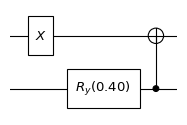

Quantum circuit for deuteron N=3.


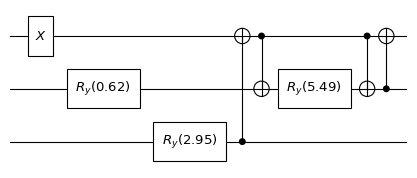

In [3]:
from utils import DeuteronUCC2, DeuteronUCC3

# Simplified UCC circuit for H_2
cir2 = DeuteronUCC2()
print("Quantum circuit for deuteron N=2.")
cir2.plot()

# Simplified UCC circuit for H_3
cir3 = DeuteronUCC3()
print("Quantum circuit for deuteron N=3.")
cir3.plot()

## 利用变分量子算法（VQE）计算哈密顿量基态能量
量桨为基态能量计算问题提供了一个简单易用的`GroundStateSolver`接口，我们只需要把哈密顿量和对应的量子线路输入就可以方便地得到基态能量。接下来我们就用它来计算氘核的结合能。 

In [5]:
import paddle
from paddle.optimizer import Adam
from paddle_quantum.qchem import GroundStateSolver

paddle.seed(126)

binding_e = []
for ham, cir in [(deut_h_2, cir2), (deut_h_3, cir3)]:
    solver = GroundStateSolver(Adam, num_iterations=100, tol=1e-5)
    e, _ = solver.solve(cir, ham=ham, learning_rate=0.5)
    binding_e.append(e)

print(f"Binding energy (N=2): exact=-1.749, numerical={binding_e[0]:.5f}, relative_error={abs(binding_e[0]-(-1.749))/1.749:.5f}.")
print(f"Binding energy (N=3): exact=-2.046, numerical={binding_e[1]:.5f}, relative_error={abs(binding_e[1]-(-2.046))/2.046:.5f}.")

Binding energy (N=2): exact=-1.749, numerical=-1.74849, relative_error=0.00029.
Binding energy (N=3): exact=-2.046, numerical=-2.04567, relative_error=0.00016.


## 哈密顿量 $\hat{H}_2$ 的结合能随参数 $\theta$ 的变化
由于哈密顿量 $\hat{H}_2$ 只有一个变分参数 $\theta$，我们可以画出它的期望值 $\lang\hat{H}_2\rangle$ 随 $\theta$ 变化的曲线，然后检查一下我们前面的VQE算法是否找到了真正的基态能量。

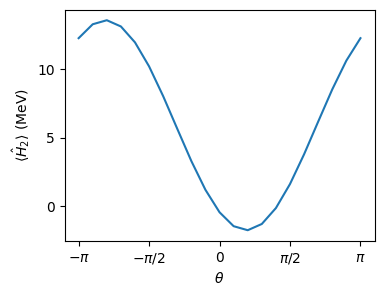

In [6]:
import numpy as np
import matplotlib.pyplot as plt

angles = np.arange(-np.pi, 1.1*np.pi, 0.1*np.pi)
qm_expectvals = []
for theta in angles:
    cir = DeuteronUCC2(theta)
    psi = cir()
    qm_expectvals.append(psi.expec_val(deut_h_2))
print(f"The minimum value is {min(qm_expectvals):.5f}.")

fig = plt.figure(figsize=(4, 3))
ax = fig.gca()
ax.plot(angles, qm_expectvals)
ax.set_xlabel(r"$\theta$")
ax.set_ylabel(r"$\langle\hat{H}_2\rangle$ (MeV)")
ax.set_xticks([-np.pi, -np.pi/2, 0.0, np.pi/2, np.pi], [r"$-\pi$", r"$-\pi/2$", r"$0$", r"$\pi/2$", r"$\pi$"])
ax.set_yticks([0, 5, 10], ["0", "5", "10"])
plt.show()

## 参考文献
\[1\] Dumitrescu E F, McCaskey A J, Hagen G, et al. Cloud quantum computing of an atomic nucleus[J]. Physical review letters, 2018, 120(21): 210501.

\[2\] [什么是约当-魏格纳（Jordan-Wigner）变换？](https://www.zhihu.com/question/457552295?utm_id=0)